# ベイズ統計の勉強が捗る　pymc3のケーススタディ(Bayesian mediation analysis)　解説

https://qiita.com/kkb0318/items/c43d563aa3868789299c

https://docs.pymc.io/en/v3/pymc-examples/examples/case_studies/mediation_analysis.html


In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import seaborn as sns

from pandas import DataFrame

%config InlineBackend.figure_format = 'retina'
plt.rcParams.update({"font.size": 14})
seed = 42
rng = np.random.default_rng(seed);

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


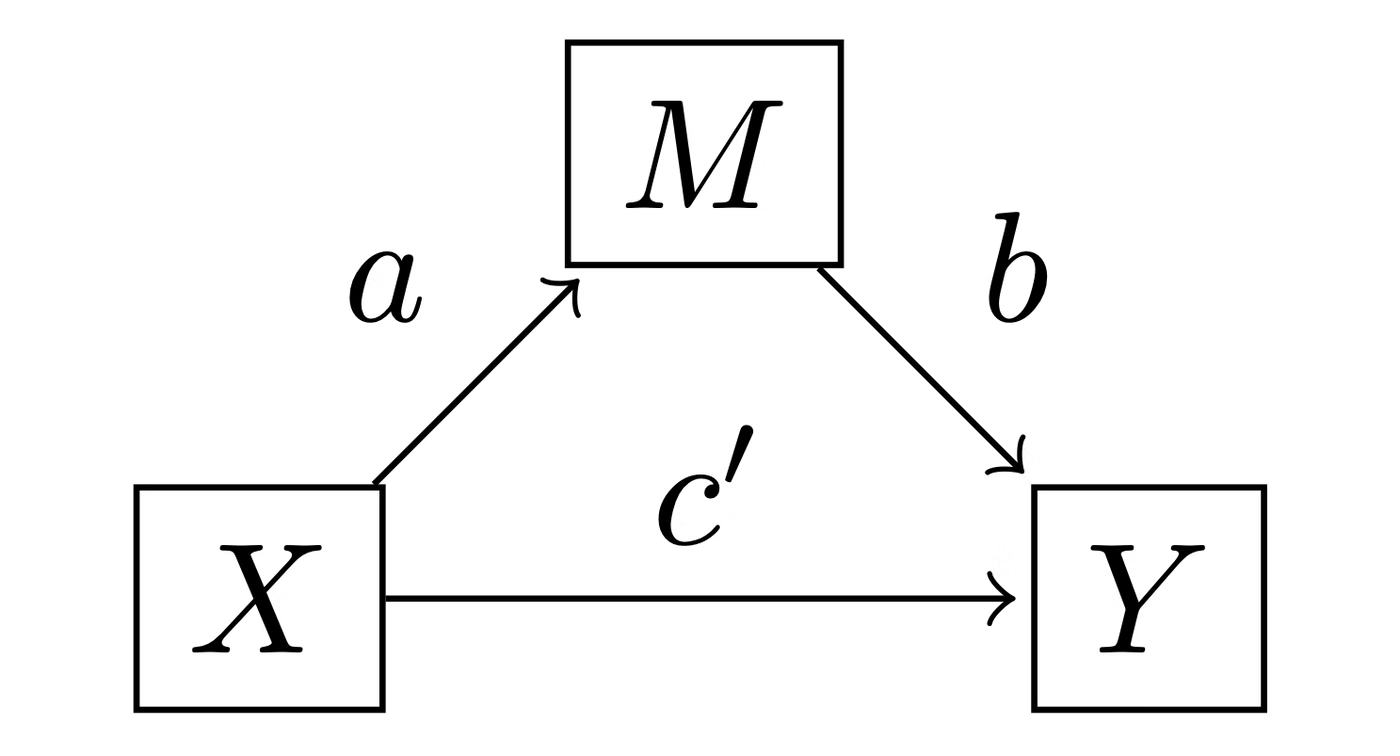

$$
{M = a \times X \\
Y = c' \times X + b \times M
}
$$

$$
{M \sim Normal(i_M + a \times X, \sigma_M) \\
Y \sim Normal(i_Y + c' \times X + b \times M, \sigma_Y)
}
$$

a, b, cprime = 0.5, 0.6, 0.3

im, iy, σm, σy = 2.0, 0.0, 0.5, 0.5


True direct effect = 0.3
True indirect effect = 0.3
True total effect = 0.6


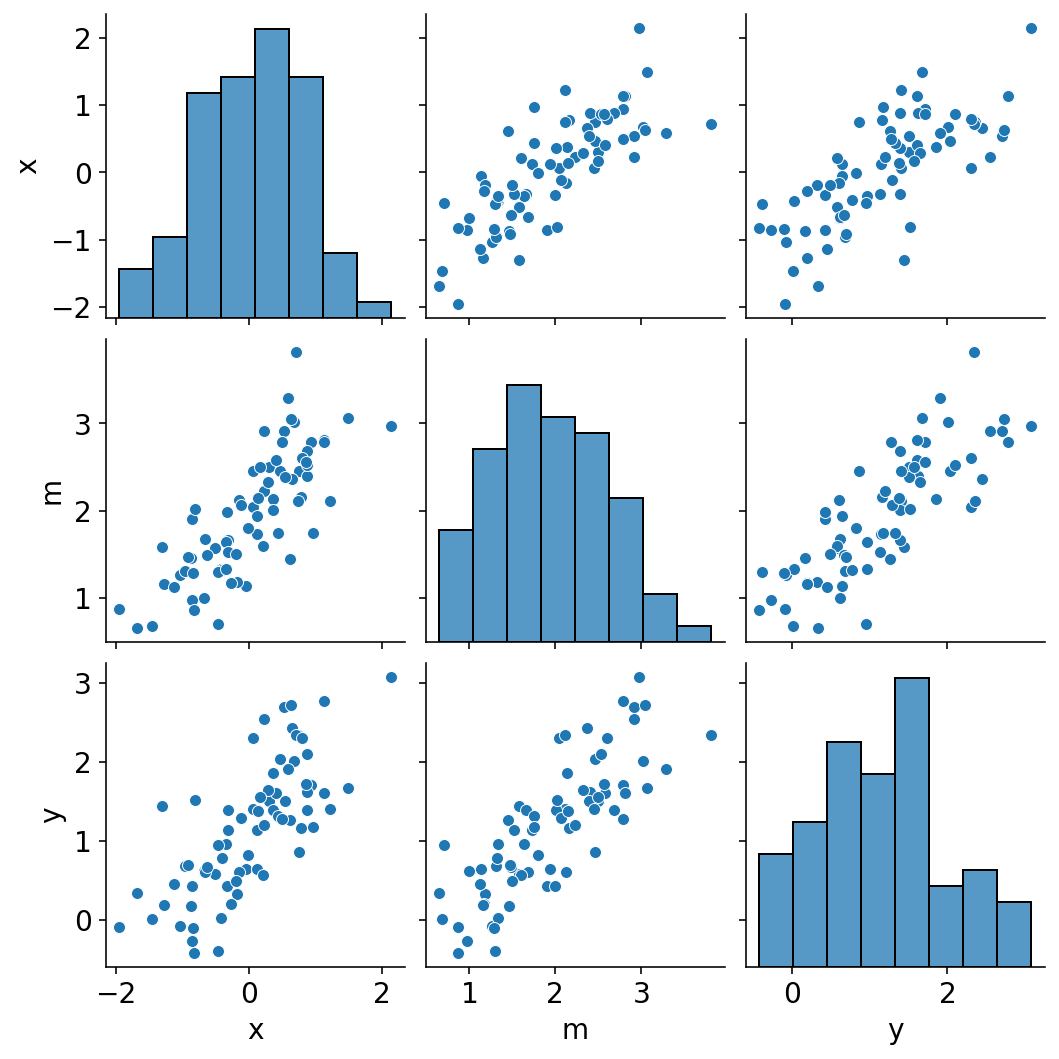

In [2]:
def make_data():
    N = 75
    a, b, cprime = 0.5, 0.6, 0.3
    im, iy, σm, σy = 2.0, 0.0, 0.5, 0.5
    x = rng.normal(loc=0, scale=1, size=N)
    m = im + rng.normal(loc=a * x, scale=σm, size=N)
    y = iy + (cprime * x) + rng.normal(loc=b * m, scale=σy, size=N)
    print(f"True direct effect = {cprime}")
    print(f"True indirect effect = {a*b}")
    print(f"True total effect = {cprime+a*b}")
    return x, m, y


x, m, y = make_data()

sns.pairplot(DataFrame({"x": x, "m": m, "y": y}));

In [3]:
def mediation_model(x, m, y):
    with pm.Model() as model:
        x = pm.Data("x", x)
        y = pm.Data("y", y)
        m = pm.Data("m", m)

        # intercept priors
        im = pm.Normal("im", mu=0, sigma=10) # とりあえず標準偏差10(95%信頼区間: 0 ± 19.6)という少し広めの幅でとっている
        iy = pm.Normal("iy", mu=0, sigma=10)
        # slope priors
        a = pm.Normal("a", mu=0, sigma=10)
        b = pm.Normal("b", mu=0, sigma=10)
        cprime = pm.Normal("cprime", mu=0, sigma=10)
        # noise priors
        σm = pm.HalfCauchy("σm", 1)
        σy = pm.HalfCauchy("σy", 1)

        # likelihood
        pm.Normal("m_likehood", mu=im + a * x, sigma=σm, observed=m)
        pm.Normal("y_likehood", mu=iy + b * m + cprime * x, sigma=σy, observed=y)

        # calculate quantities of interest
        indirect_effect = pm.Deterministic("indirect effect", a * b)
        total_effect = pm.Deterministic("total effect", a * b + cprime)

    return model

In [4]:
model = mediation_model(x, m, y)

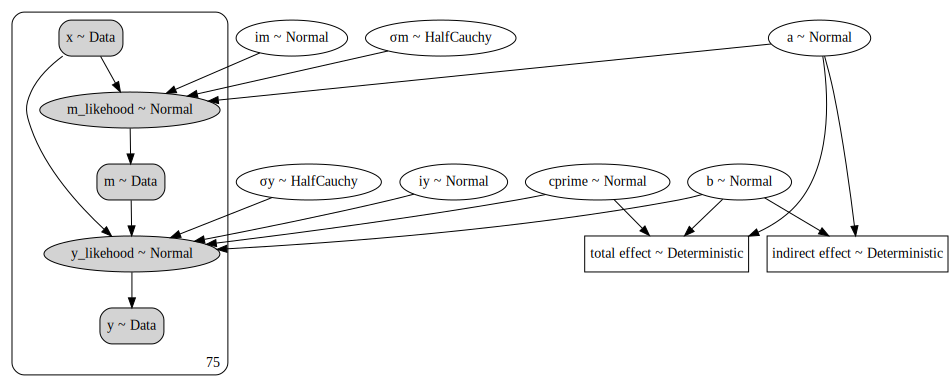

In [5]:
pm.model_to_graphviz(model)

In [6]:
with model:
    result = pm.sample(
        2000,
        tune=4000,
        chains=3,
        target_accept=0.9,
        random_seed=42
    )
        #return_inferencedata=True,
        #idata_kwargs={"dims": {"x": ["obs_id"], "m": ["obs_id"], "y": ["obs_id"]}},


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
NUTS: [σy, σm, cprime, b, a, iy, im]
Sampling 3 chains, 0 divergences: 100%|██████████| 18000/18000 [00:20<00:00, 862.42draws/s] 


C:\VApps\Anaconda3\lib\site-packages\arviz\data\io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


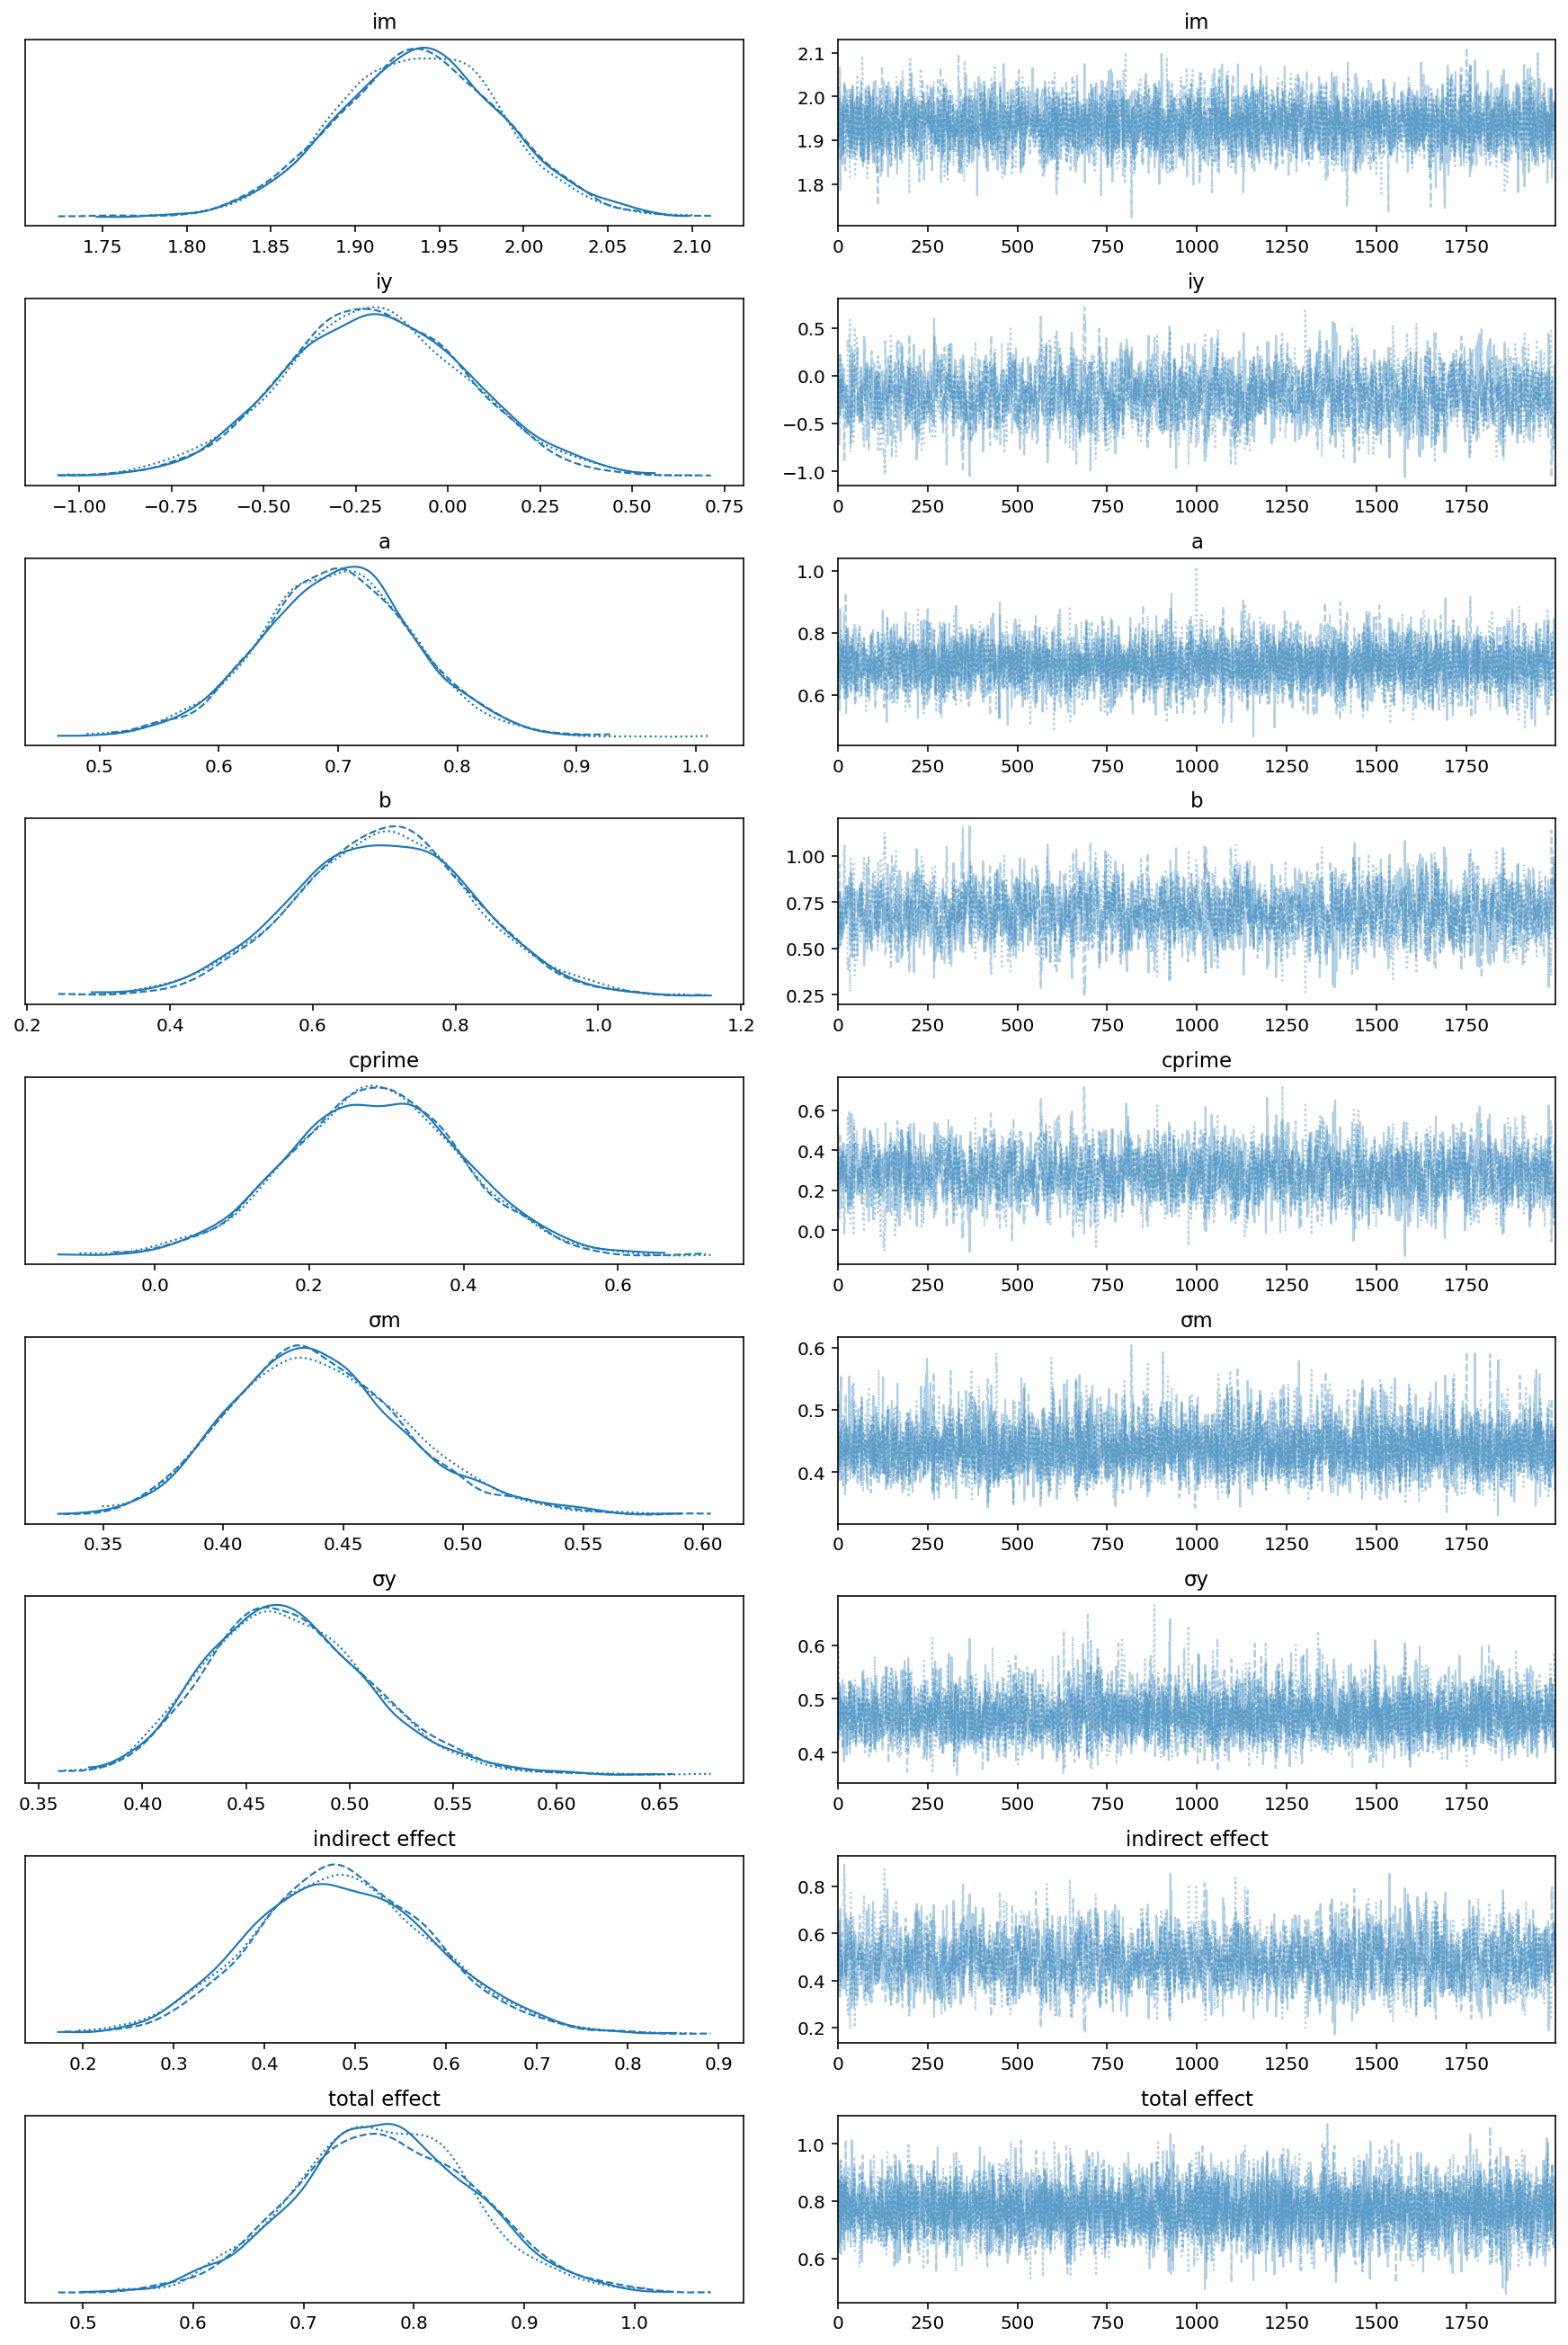

In [7]:
az.plot_trace(result);

- 例えばパラメータbの左図に着目すると、平均おおよそ0.7の事後分布になっている
- サンプリング時にchains=2というパラメータ. 今回は２回と設定しているため、上図のグラフに波線と実線の２つの線が表れ
- これら２つの確率分布を比較して、似た形状になっていることが、計算がきちんと収束していると判定できる


C:\VApps\Anaconda3\lib\site-packages\arviz\data\io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


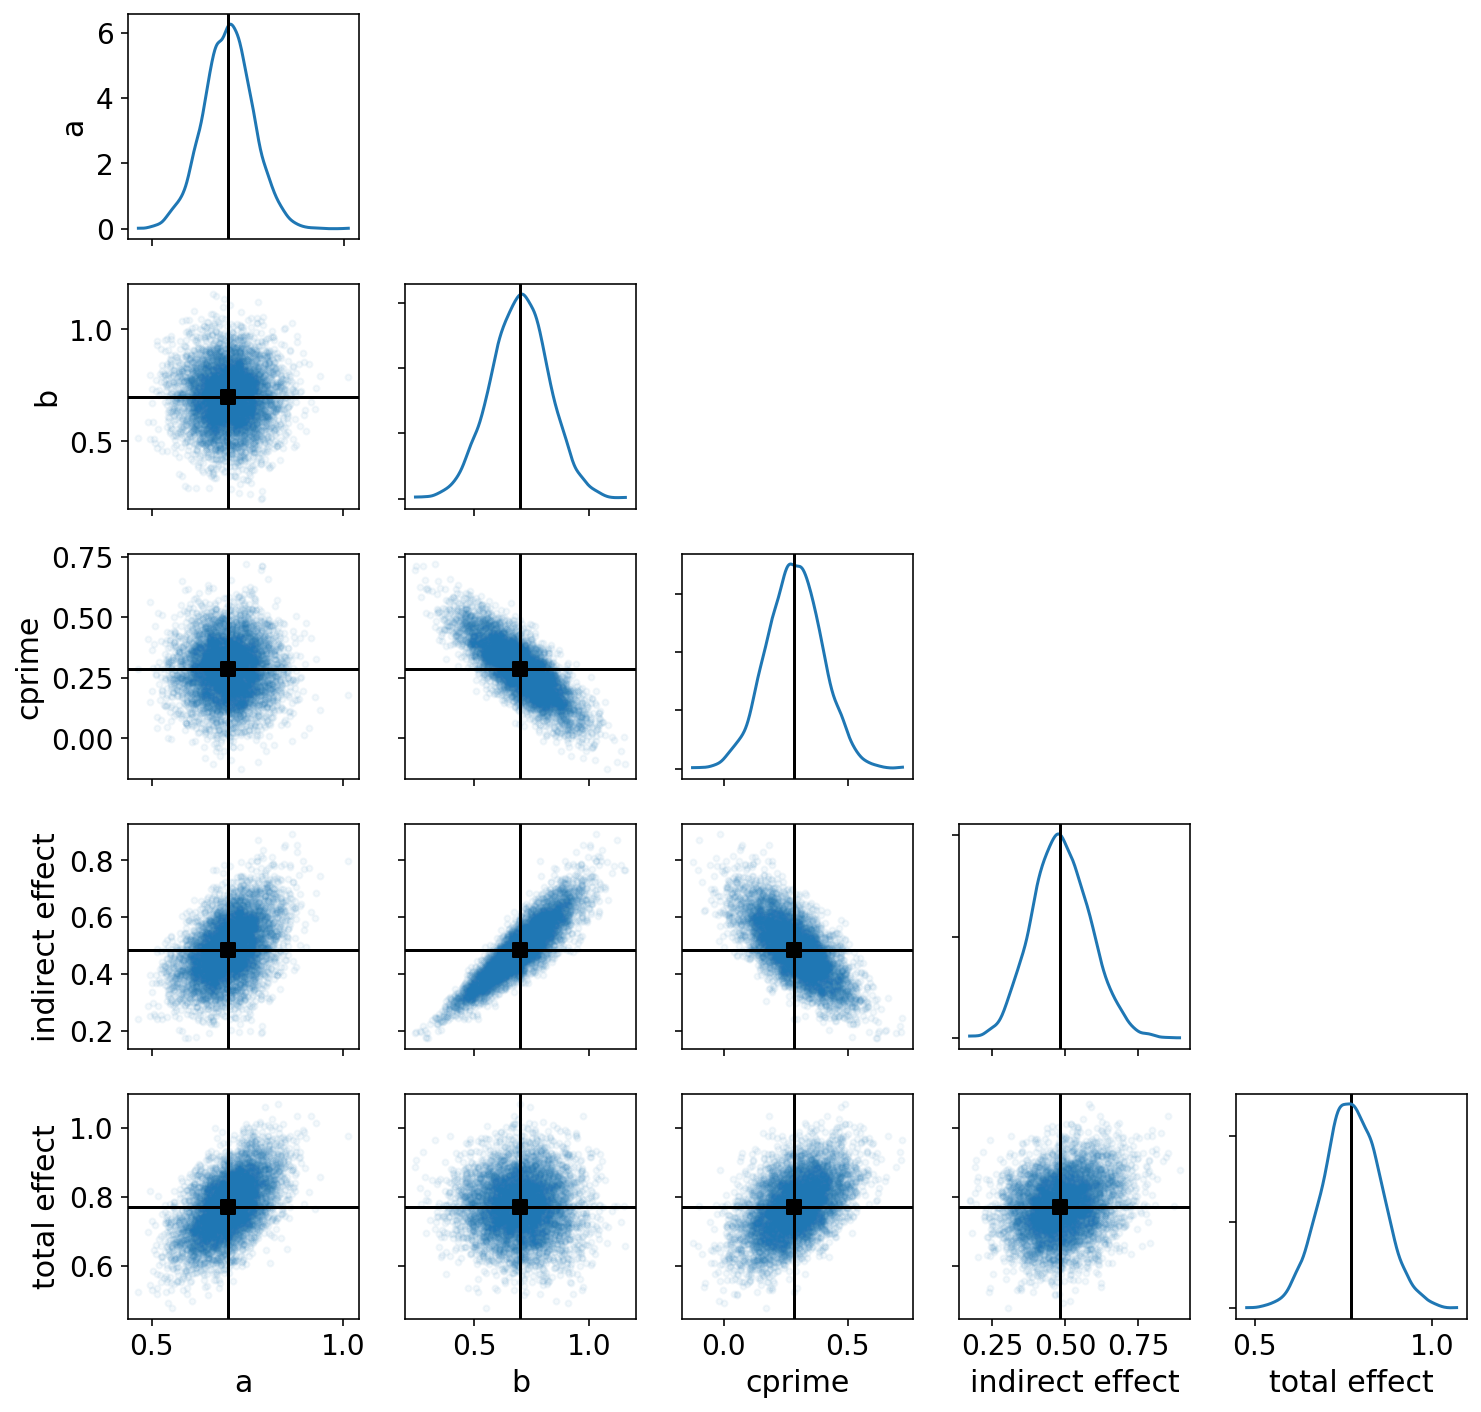

In [8]:
az.plot_pair(
    result,
    marginals=True,
    point_estimate="median",
    figsize=(12, 12),
    scatter_kwargs={"alpha": 0.05},
    var_names=["a", "b", "cprime", "indirect effect", "total effect"],
);

- 例えば(b)-(indirect effect)の関係に着目すると、bが大きくなるほどindirect effectが大きい値をとりやすくなる(右上がりの分布)になっていることがわかります。


C:\VApps\Anaconda3\lib\site-packages\arviz\data\io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


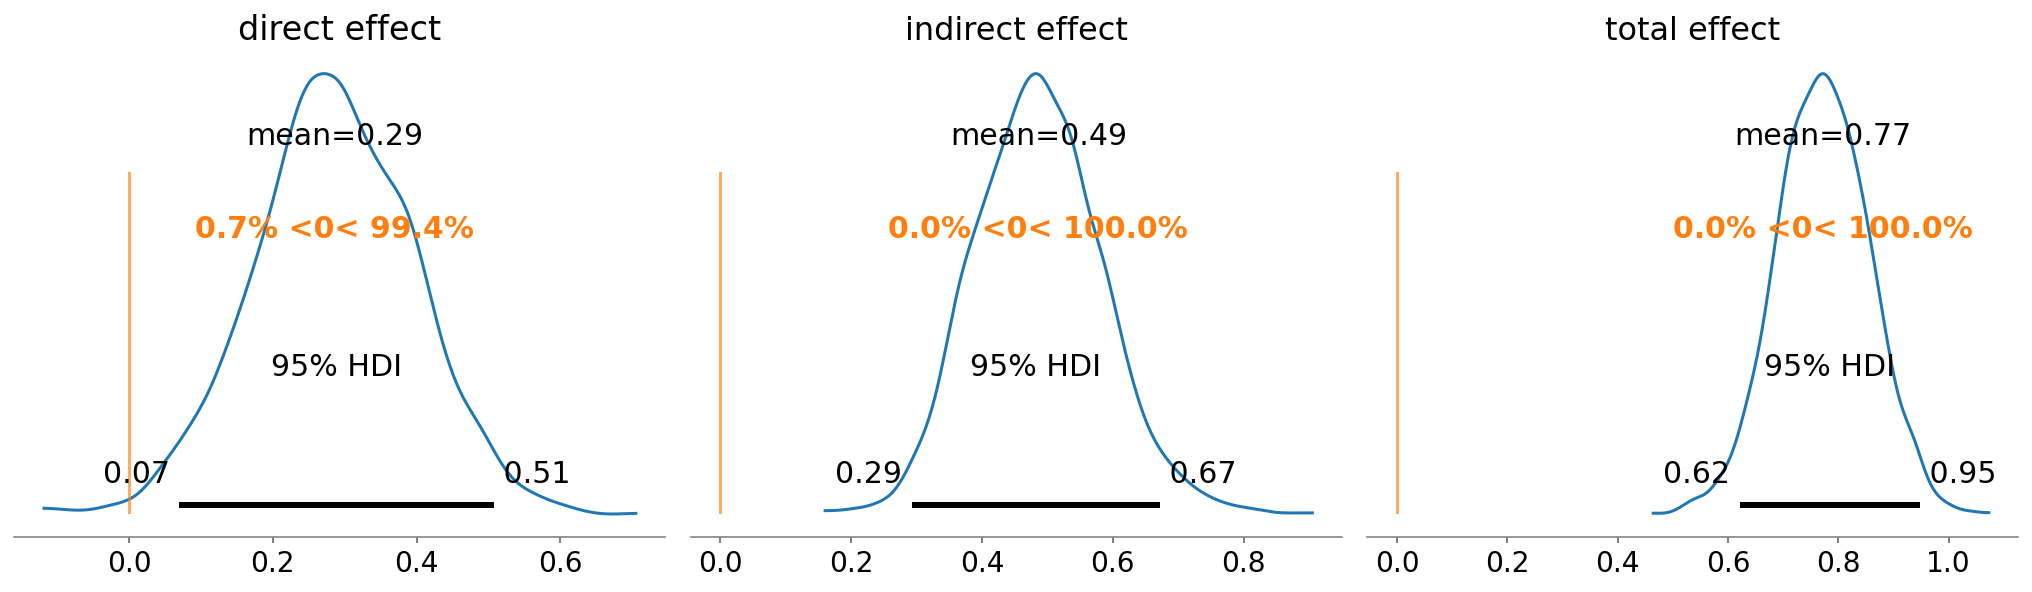

In [12]:
ax = az.plot_posterior(
    result,
    var_names=["cprime", "indirect effect", "total effect"],
    ref_val=0,
    hdi_prob=0.95,
    figsize=(14, 4),
)
ax[0].set(title="direct effect");

In [9]:
with pm.Model() as total_effect_model:
    _x = pm.Data("_x", x)
    iy = pm.Normal("iy", mu=0, sigma=1)
    c = pm.Normal("c", mu=0, sigma=1)
    σy = pm.HalfCauchy("σy", 1)
    μy = iy + c * _x
    _y = pm.Normal("_y", mu=μy, sd=σy, observed=y)

In [10]:
total_effect_model

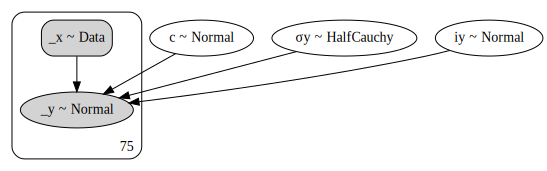

In [11]:
pm.model_to_graphviz(total_effect_model)

In [13]:
with total_effect_model:
    total_effect_result = pm.sample(
        2000,
        tune=4000,
        chains=3,
        target_accept=0.9,
        random_seed=42,
    )
        #return_inferencedata=True,
        #idata_kwargs={"dims": {"x": ["obs_id"], "y": ["obs_id"]}},


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
NUTS: [σy, c, iy]
Sampling 3 chains, 0 divergences: 100%|██████████| 18000/18000 [00:09<00:00, 1964.44draws/s]


C:\VApps\Anaconda3\lib\site-packages\arviz\data\io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
C:\VApps\Anaconda3\lib\site-packages\arviz\data\io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


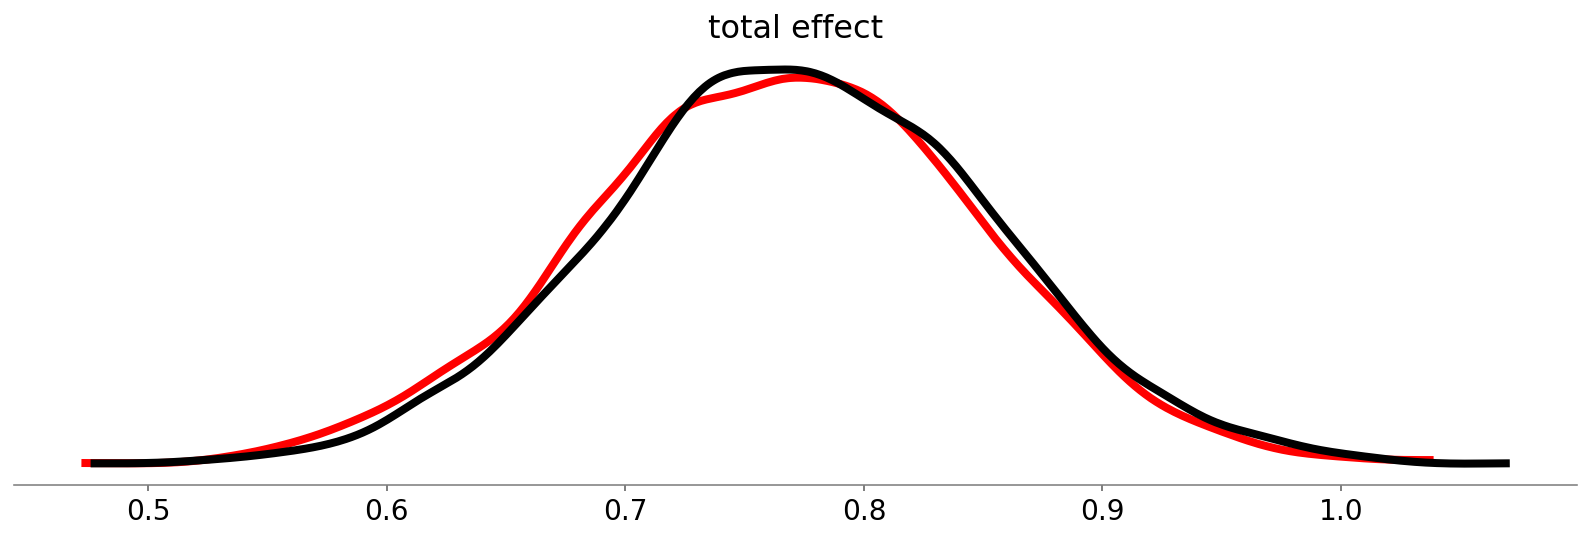

In [14]:
fig, ax = plt.subplots(figsize=(14, 4))
az.plot_posterior(
    total_effect_result, var_names=["c"], point_estimate=None, hdi_prob="hide", c="r", lw=4, ax=ax
)
az.plot_posterior(
    result, var_names=["total effect"], point_estimate=None, hdi_prob="hide", c="k", lw=4, ax=ax
);